# Data Cleaning and Modification

Main dataset is from **Kaggle**, and contains **Spotify** tracks and their corresponding metadata: <br>
https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/data

In [ ]:
#Cleaning the raw dataset and saving a cleaned version: 

import pandas as pd

# Load raw data
tracks_df = pd.read_csv("dataset.csv")

# Drop old index column if it exists
if "Unnamed: 0" in tracks_df.columns:
    tracks_df = tracks_df.drop(columns=["Unnamed: 0"])

# Remove songs that share the same title (keep the first occurrence)
tracks_df = tracks_df.drop_duplicates(subset="track_name", keep="first")

# Discard any rows that contain missing values in *any* column
#tracks_df = tracks_df.dropna(axis=0, how="any")

# Convert explicit flag from boolean to integer (0/1)
tracks_df["explicit"] = tracks_df["explicit"].map({True: 1, False: 0})

# Create a helper field for searching: "Track name - artist1, artist2, ..."
def make_search_string(row):
    artist_list = [a.strip() for a in str(row["artists"]).split(";")]
    return f'{row["track_name"]} - {", ".join(artist_list)}'

tracks_df["search_string"] = tracks_df.apply(make_search_string, axis=1)

# Save cleaned version to disk
tracks_df.to_csv("dataset_clean.csv", index=False)

# Inspect the first few feature columns (adjust indices if needed)
tracks_df.columns.values[4:19]


array(['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature'], dtype=object)

### API requesting to __last.fm__:

last.fm is a website which contains extra metadata (like playcount, listeners, duration (ms) and tags). 

Make an account at: <br>
https://www.last.fm/api/account/create

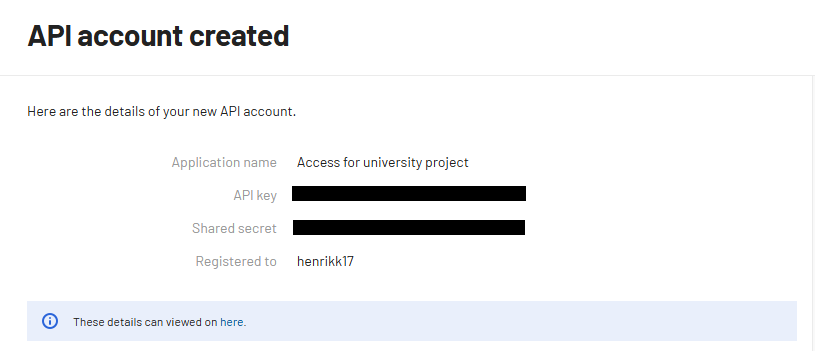

In [ ]:
#Fill out - and keep it private!:

API_KEY = ""        #KEEP SECRET - DON'T SHARE WITH OTHERS
API_SECRET = ""     #KEEP SECRET - DON'T SHARE WITH OTHERS

# (^) Be sure to leave this part blank, when you upload to Git! 


###

#Making the api.env file if it doesn't already exist. 

import os
API_file = "api.env"

if not os.path.exists(API_file):
    #Making the env file for API keys
    !echo "LASTFM_API_KEY={API_KEY}" > api.env
    !echo "LASTFM_API_SECRET={API_SECRET}" >> api.env
    !chmod 600 api.env


In [ ]:
from pathlib import Path


#Loading the API keys from the api.env file into a dict: 

def load_env_file(path="api.env"):
    """
    Very small .env-style loader.
    Returns a dict like {"LASTFM_API_KEY": "...", "LASTFM_API_SECRET": "..."}.
    """
    env_vars = {}
    env_path = Path(path)

    if not env_path.exists():
        raise FileNotFoundError(f"{path} not found in current folder")

    with env_path.open() as f:
        for line in f:
            line = line.strip()
            # skip empty lines and comments
            if not line or line.startswith("#"):
                continue
            if "=" not in line:
                continue
            key, value = line.split("=", 1)
            env_vars[key.strip()] = value.strip()

    return env_vars

env = load_env_file("api.env")
LASTFM_API_KEY = env.get("LASTFM_API_KEY")

if not LASTFM_API_KEY:
    raise ValueError("LASTFM_API_KEY not found or empty in api.env")


In [ ]:
#Pip install dotenv package if not already installed: 

prompt = input("You sure you wanna pip install the dotenv package? [y]")

if prompt.lower() == "y":
    !pip install python-dotenv


In [ ]:
import os
import requests
from dotenv import load_dotenv
import time

LASTFM_ENDPOINT = "https://ws.audioscrobbler.com/2.0/"



#Code for fetching metadata about a track from the Last.fm API: 



def get_lastfm_metadata(artist_name: str, song_title: str):
    """
    Query Last.fm for basic track info.

    Returns a dict with playcount, listeners, duration and semicolon-separated tags,
    or None if nothing useful is returned.
    """
    params = {
        "method": "track.getInfo",
        "api_key": LASTFM_API_KEY,
        "artist": artist_name,
        "track": song_title,
        "autocorrect": 1,      # let Last.fm fix common typos
        "format": "json",
    }

    try:
        response = requests.get(LASTFM_ENDPOINT, params=params, timeout=5)
        response.raise_for_status()
        payload = response.json()

        if "error" in payload:
            print("Last.fm error:", payload)
            return None

        track_obj = payload.get("track", {})

        playcount = track_obj.get("playcount")
        listeners = track_obj.get("listeners")
        duration = track_obj.get("duration")

        playcount = int(playcount) if playcount is not None else None
        listeners = int(listeners) if listeners is not None else None
        duration = int(duration) if duration is not None else None

        raw_tags = track_obj.get("toptags", {}).get("tag", [])
        if isinstance(raw_tags, dict):
            raw_tags = [raw_tags]

        tag_names = []
        for t in raw_tags:
            name = t.get("name")
            if isinstance(name, str):
                tag_names.append(name.lower())

        tag_string = ";".join(tag_names) if tag_names else None

        return {
            "lfm_playcount": playcount,
            "lfm_listeners": listeners,
            "lfm_duration_ms": duration,
            "lfm_tags": tag_string,
        }

    except Exception as e:
        print("Request failed:", e)
        return None


In [ ]:
#Example usage for fetching metadata about a track with the last.fm API: 

test_artist = "Daft Punk"
test_track = "Get Lucky"

info = get_lastfm_metadata(test_artist, test_track)
print(info)


{'lfm_playcount': 1833407, 'lfm_listeners': 195550, 'lfm_duration_ms': 233000, 'lfm_tags': None}


In [ ]:
# Reading the cleaned dataset and preparing for API requests for every track: 

import pandas as pd
from tqdm.auto import tqdm
import time

# Load cleaned data
tracks_df = pd.read_csv("dataset_clean.csv")

# Optional: sort by popularity if you have that column, so you enrich the “important” tracks first
if "popularity" in tracks_df.columns:
    tracks_df = tracks_df.sort_values("popularity", ascending=False).reset_index(drop=True)

# Limit how many tracks you hit the API with (for development)
N = 2000  # you can increase later
subset_idx = tracks_df.index[:N]


In [ ]:
# Prepare new columns in dataframe for the metadata from last.fm: 

for col in ["lfm_playcount", "lfm_listeners", "lfm_duration_ms", "lfm_tags"]:
    tracks_df[col] = pd.NA


In [37]:
#Fetching the metadata for each track: 

# Warning: This part will take a while!


for idx in tqdm(subset_idx):
    row = tracks_df.loc[idx]
    song_title = row["track_name"]
    main_artist = str(row["artists"]).split(";")[0].strip()

    meta = get_lastfm_metadata(main_artist, song_title)

    if meta is not None:
        tracks_df.at[idx, "lfm_playcount"] = meta["lfm_playcount"]
        tracks_df.at[idx, "lfm_listeners"] = meta["lfm_listeners"]
        tracks_df.at[idx, "lfm_duration_ms"] = meta["lfm_duration_ms"]
        tracks_df.at[idx, "lfm_tags"] = meta["lfm_tags"]

    # Be polite to the API
    time.sleep(0.25)   # ~4 requests/second


  1%|▏         | 29/2000 [00:17<16:40,  1.97it/s]

Last.fm error: {'error': 6, 'message': 'Track not found', 'links': []}


 16%|█▌        | 315/2000 [02:56<24:38,  1.14it/s]

Last.fm error: {'error': 6, 'message': 'Track not found', 'links': []}


 17%|█▋        | 334/2000 [03:07<21:30,  1.29it/s]

Request failed: HTTPSConnectionPool(host='ws.audioscrobbler.com', port=443): Read timed out. (read timeout=5)


 20%|██        | 403/2000 [03:48<13:10,  2.02it/s]

Last.fm error: {'error': 6, 'message': 'Track not found', 'links': []}


 27%|██▋       | 535/2000 [05:10<16:06,  1.52it/s]

Last.fm error: {'error': 6, 'message': 'Track not found', 'links': []}


 53%|█████▎    | 1053/2000 [10:40<09:45,  1.62it/s]

Request failed: HTTPSConnectionPool(host='ws.audioscrobbler.com', port=443): Read timed out. (read timeout=5)


 64%|██████▍   | 1288/2000 [13:11<14:22,  1.21s/it]

Last.fm error: {'error': 6, 'message': 'Track not found', 'links': []}


 76%|███████▋  | 1527/2000 [15:29<04:19,  1.82it/s]

Last.fm error: {'error': 6, 'message': 'Track not found', 'links': []}


 84%|████████▍ | 1690/2000 [16:57<05:34,  1.08s/it]

Request failed: HTTPSConnectionPool(host='ws.audioscrobbler.com', port=443): Read timed out. (read timeout=5)


100%|██████████| 2000/2000 [20:18<00:00,  1.64it/s]


Note: On an average desktop, this code takes approximately 20 minutes to run. 

In [ ]:
#Save the updated version of the dataset with the additional last.fm metadata: 

tracks_df.to_csv("dataset_clean_with_lastfm.csv", index=False)

print(f"Saved dataset with {len(tracks_df)} tracks and {len(tracks_df.columns)} columns")

#Note: If only N = 2000 amount of tracks are fetched, only the first 2000 rows will have last.fm metadata. 
#(Assuming no errors occurred during the API requests)

Saved dataset with 73608 tracks and 26 columns
